<a href="https://colab.research.google.com/github/David-Bustos/Learning_Proyects/blob/master/IBM%20-%20Data%20Science/IBM_Coursera_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal location for Coffee related business in Santiago of Chile.

### Import basics libreries

In [0]:
import numpy as np
import pandas as pd
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from google.colab import files
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
stgo_coffees = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/df_coffees.csv")
stgo_coffees.head()

,id,Coffee Name,CN Latitude,CN Longitude,Category,Commune
0,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café,SAN MIGUEL
1,58530b0edebdf67a4d7a812d,Starbucks,-33.451241,-70.679164,Coffee Shop,ESTACIÓN CENTRAL
2,55e7894a498ea1b894714623,Starbucks,-33.516439,-70.716791,Coffee Shop,CERRILLOS
3,513363dbe4b08f70f9cef67d,Caffe Codice,-33.498026,-70.653820,Coffee Shop,SAN MIGUEL
4,4bcb2d58937ca593f4f7a892,Starbucks,-33.483698,-70.750360,Coffee Shop,MAIPÚ


In [0]:
nearby_venues = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/df_nearby_venues2.csv")
print(nearby_venues.shape)
nearby_venues.head()

(12318, 8)


,id,Coffee Name,CN Latitude,CN Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Cocó Café,-33.497172,-70.654912,Café
1,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Kingu Sushi,-33.498741,-70.653602,Sushi Restaurant
2,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Caffe Codice,-33.498026,-70.653820,Coffee Shop
3,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Okita - Peruvian & Japanese,-33.497792,-70.655281,Peruvian Restaurant
4,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Papa John's,-33.499511,-70.653993,Pizza Place


In [0]:
similar_venues = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/df_similar_venues.csv")
similar_venues.head()

,Commune,Commune Latitude,Commune Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CERRILLOS,-33.487987,-70.703081,4ea31634f5b9efc001b7047d,Parque Bicentenario Cerrillos,-33.496736,-70.699234,Park
1,CERRILLOS,-33.487987,-70.703081,577bca5b498e3c4f7d0b9928,Centro Nacional de Arte Contemporáneo,-33.494973,-70.704201,Art Gallery
2,CERRILLOS,-33.487987,-70.703081,4e0b110852b1fe83d5497242,Centro de Abastecimiento Lo Valledor,-33.482618,-70.684434,Farmers Market
3,CERRILLOS,-33.487987,-70.703081,4c952d7772dd224be74ea191,Parque André Jarlan,-33.487446,-70.665522,Park
4,CERRILLOS,-33.487987,-70.703081,50c72c06e4b049f73733e0b3,HOMY,-33.517764,-70.718194,Department Store


### Web scraping

In [0]:
url = "https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile"

tables = pd.read_html(url)
tables

[                                                    0  ...                            3
 0   Comunas en la Provincia de Santiago  Cerrillos...  ...                          NaN
 1                 Comunas en la Provincia de Santiago  ...                          NaN
 2                                           Cerrillos  ...                          NaN
 3                                         Cerro Navia  ...                          NaN
 4                                            Conchalí  ...                          NaN
 5                                           El Bosque  ...                          NaN
 6                                    Estación Central  ...                          NaN
 7                                          Huechuraba  ...                          NaN
 8                                       Independencia  ...                          NaN
 9                                         La Cisterna  ...                          NaN
 10                  

In [0]:
#Transform to Dataframe
df_stgo = pd.DataFrame(tables[3])
df_stgo = df_stgo[['Comuna','Población (2017)?']]
df_stgo.columns=(['Commune', 'Population 2017'])

df_stgo

,Commune,Population 2017
0,Cerrillos,80832
1,Cerro Navia,132622
2,Conchalí,126955
3,El Bosque,162505
4,Estación Central,147041
5,Huechuraba,98671
6,Independencia,100281
7,La Cisterna,90119
8,La Florida,366916
9,La Granja,116571


In [0]:
total_population = df_stgo['Population 2017'].sum(axis = 0, skipna = True)
print('La Población total de las 35 Comunas es de '+ str(total_population) + ' habitantes')

La Población total de las 35 Comunas es de 6179183 habitantes


### Geolocator

#### Alternative 1 - Geopy Nominatim

In [0]:
df_stgo['Latitude']=""
df_stgo['Longitude']=""

for i in range(0,len(df_stgo.index)):
    try:
        
        address = df_stgo.iloc[i,0]+' Comuna, Santiago Chile'
        #print(address)
        geolocator = Nominatim(user_agent="007")
        location = geolocator.geocode(address)
        df_stgo.iloc[i,2] = location.latitude
        df_stgo.iloc[i,3] = location.longitude
        latitude = location.latitude
        longitude = location.longitude
        #print('The geograpical coordinate of Commune are {}, {}.'.format(latitude, longitude))
    
    except AttributeError:
        pass
    
df_stgo

In [0]:
address = 'Santiago Chile'

geolocator = Nominatim(user_agent="007")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Santiago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Santiago are -33.4377968, -70.6504451.


In [0]:
df_stgo.iloc[33,2] = latitude
df_stgo.iloc[33,3] = longitude
df_stgo = df_stgo.astype({"Latitude":'float64', "Longitude":'float64'})

#### Alternative 2 - Geocoder

In [0]:
%%capture
!pip install geocoder

In [0]:
import geocoder
g = geocoder.osm('Santiago Chile') # arcgis / osm 
g.latlng

[-33.4377968, -70.6504451]

In [0]:
df_stgo['Latitude']=""
df_stgo['Longitude']=""

for i in range(0,len(df_stgo.index)):
    try:
        
        address = df_stgo.iloc[i,0]+' Comuna, Santiago Chile'
        #print(address)
        g = geocoder.osm(address)
        df_stgo.iloc[i,2] = g.lat
        df_stgo.iloc[i,3] = g.lng
        #latitude = location.latitude
        #longitude = location.longitude
        #print('The geograpical coordinate of Commune are {}, {}.'.format(latitude, longitude))
    
    except AttributeError:
        pass
    
df_stgo

,Commune,Population 2017,Latitude,Longitude
0,CERRILLOS,80832,-33.488,-70.7031
1,CERRO NAVIA,132622,-33.4289,-70.7307
2,CONCHALÍ,126955,-33.396,-70.6708
3,EL BOSQUE,162505,-33.556,-70.6657
4,ESTACIÓN CENTRAL,147041,-33.4536,-70.6899
5,HUECHURABA,98671,-33.3745,-70.6363
6,INDEPENDENCIA,100281,-33.4223,-70.6555
7,LA CISTERNA,90119,-33.5346,-70.6644
8,LA FLORIDA,366916,-33.5204,-70.6006
9,LA GRANJA,116571,-33.5431,-70.633


In [0]:
g = geocoder.arcgis('Santiago Chile') # arcgis / osm 

df_stgo.iloc[33,2] = g.lat
df_stgo.iloc[33,3] = g.lng
df_stgo = df_stgo.astype({"Latitude":'float64', "Longitude":'float64'})

### Map Communes

In [0]:
map_stgo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, commune, population in zip(df_stgo['Latitude'], df_stgo['Longitude'], df_stgo['Commune'], df_stgo['Population 2017']):
    label = '{}, {}'.format(commune, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='orange',
        fill=True,
        fill_color='##ff7e1c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stgo)

        #folium.Marker(
        #[lat, lng],
        #popup=label,
        #icon=folium.Icon(color='brown', icon="home", prefix='fa'),
        #).add_to(map_coffees) 

from folium.plugins import MeasureControl
map_stgo.add_child(MeasureControl())

from folium.plugins import FloatImage
link = ('https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://d15cw65ipctsrr.cloudfront.net/ed/4131809fe511e8937a7926bc59e37f/Professional-Certificate---Data-Science---600x600---Blu-Text.png?auto=format%2Ccompress&dpr=1&w=150&h=150&fit=fill&bg=FFF')
FloatImage(link, bottom=5, left=85).add_to(map_stgo)
    
map_stgo

### Foursquare API - Credentials

In [0]:
CLIENT_ID = 'UGCGU02DLNZBUCSXX02JC32IFROLPBL51X2MCFC3GSDQFB53' # Foursquare ID
CLIENT_SECRET = 'V0VOW0VQFYNHVIHAILUA04CAR0OBWXA33ACIFMQTINLMFME4' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
CLIENT_ID = 'QGIGC40OIPFLAHA4SZRPLBFFNM1QXA4V2G2LQW5244VYY50P' # your Foursquare ID
CLIENT_SECRET = 'QSE3UMXWQFRONXR4SACUKZJ1HY3HMVYZM1IOT3B1EZXWN0YQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
CLIENT_ID = 'XNMD2E4XZXZ4BIHWUA24BQ2HMP1A25MFIAT5GXITZIWMA0T4' # Foursquare ID
CLIENT_SECRET = '25KDYDWFLH2WIC0CXUSOAGGGME5A1MKFVC21V0G2USNYUAKJ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
CLIENT_ID = 'RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB' # your Foursquare ID
CLIENT_SECRET = '2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
CLIENT_ID = '0HH2B0MRFB2FALD3CL3SQAGF5KPCVO53DS5OEOKOP4MWUCJO'
CLIENT_SECRET = 'D5KMPZK1RAFC0RSUS3VCUOIAIIA2KVCOWHIP1RJX3D1L0UQS'
VERSION = '20180605' # Foursquare API version

### GET - coffee venues

In [0]:
request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": '20180605',
    "categoryId": Venues_categories_ID,
    "ll": '-33.4377968,-70.6504451',
    "radius": 100,
    "limit": 100}

results = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters).json()

results

In [0]:
def getCoffeeVenues(names, latitudes, longitudes, section='coffee', radius=5000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&section={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            section,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    coffee_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    coffee_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude',
                  'id', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(coffee_venues)

In [0]:
coffee_venues = getCoffeeVenues(names = df_stgo['Commune'], latitudes = df_stgo['Latitude'], longitudes = df_stgo['Longitude'])

In [0]:
print(coffee_venues.shape)
coffee_venues.head()

(1823, 8)


,Commune,Commune Latitude,Commune Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cerrillos,-33.487987,-70.703081,4d138254ffa36ea8c1a200db,Schoperia Del Rápido,-33.466448,-70.675482,Sandwich Place
1,Cerrillos,-33.487987,-70.703081,4cc368ea06c254819d719047,Panadería y Pastelería Croccante,-33.506452,-70.659940,Bakery
2,Cerrillos,-33.487987,-70.703081,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café
3,Cerrillos,-33.487987,-70.703081,58530b0edebdf67a4d7a812d,Starbucks,-33.451241,-70.679164,Coffee Shop
4,Cerrillos,-33.487987,-70.703081,55e7894a498ea1b894714623,Starbucks,-33.516439,-70.716791,Coffee Shop


### Data Clean & Exproratory Data Analisys - Coffee Venues

In [0]:
stgo_group = coffee_venues.groupby('Commune').count().reset_index()
stgo_group

,Commune,Commune Latitude,Commune Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cerrillos,48,48,48,48,48,48,48
1,Cerro Navia,17,17,17,17,17,17,17
2,Conchalí,39,39,39,39,39,39,39
3,El Bosque,11,11,11,11,11,11,11
4,Estación Central,100,100,100,100,100,100,100
5,Huechuraba,47,47,47,47,47,47,47
6,Independencia,100,100,100,100,100,100,100
7,La Cisterna,13,13,13,13,13,13,13
8,La Florida,31,31,31,31,31,31,31
9,La Granja,26,26,26,26,26,26,26


In [0]:
coffee_venues['Venue Category'].unique()

array(['Sandwich Place', 'Bakery', 'Café', 'Coffee Shop', 'Donut Shop',
       'Breakfast Spot', 'Restaurant', 'Tea Room', 'Fast Food Restaurant',
       'Ice Cream Shop', 'Dessert Shop', 'Snack Place', 'Deli / Bodega',
       'Bookstore', 'French Restaurant',
       'Southern / Soul Food Restaurant', 'Diner', 'Bistro',
       'Salad Place', 'Gas Station', 'Coworking Space', 'Cafeteria',
       'Gastropub', 'Vegetarian / Vegan Restaurant', 'Italian Restaurant',
       'Cupcake Shop', 'Car Wash', 'College Cafeteria', 'Pizza Place',
       'Pie Shop', 'Pub', 'Convenience Store', 'Austrian Restaurant',
       'Gourmet Shop', 'Food'], dtype=object)

In [0]:
coffee_venues['Venue Category'].value_counts()

Coffee Shop                        791
Café                               558
Tea Room                            99
Donut Shop                          83
Bakery                              59
Ice Cream Shop                      47
Restaurant                          31
Breakfast Spot                      27
Snack Place                         18
Deli / Bodega                       14
Bistro                               8
Dessert Shop                         8
Italian Restaurant                   8
Sandwich Place                       7
Cafeteria                            7
Pizza Place                          6
Convenience Store                    6
Gastropub                            6
Vegetarian / Vegan Restaurant        5
French Restaurant                    5
Diner                                5
Pie Shop                             4
Bookstore                            4
College Cafeteria                    3
Pub                                  2
Fast Food Restaurant     

In [0]:
stgo_coffees = coffee_venues[coffee_venues['Venue Category'].isin(['Coffee Shop',
                                                                   'Café',
                                                                   'Tea Room',
                                                                   'Cafeteria',
                                                                   'College Cafeteria' ])].reset_index(drop=True)
stgo_coffees

,Commune,Commune Latitude,Commune Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cerrillos,-33.487987,-70.703081,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café
1,Cerrillos,-33.487987,-70.703081,58530b0edebdf67a4d7a812d,Starbucks,-33.451241,-70.679164,Coffee Shop
2,Cerrillos,-33.487987,-70.703081,55e7894a498ea1b894714623,Starbucks,-33.516439,-70.716791,Coffee Shop
3,Cerrillos,-33.487987,-70.703081,513363dbe4b08f70f9cef67d,Caffe Codice,-33.498026,-70.653820,Coffee Shop
4,Cerrillos,-33.487987,-70.703081,4bcb2d58937ca593f4f7a892,Starbucks,-33.483698,-70.750360,Coffee Shop
...,...,...,...,...,...,...,...,...
1453,Vitacura,-33.387106,-70.576452,4b75dba1f964a520e6292ee3,Confiteria Torres,-33.414184,-70.599680,Café
1454,Vitacura,-33.387106,-70.576452,518433da498e622f0fb0eb80,Starbucks,-33.417900,-70.600439,Coffee Shop
1455,Vitacura,-33.387106,-70.576452,4e89c7455c5c4e28ce3b09cb,Starbucks,-33.384339,-70.530644,Coffee Shop
1456,Vitacura,-33.387106,-70.576452,525bdf1811d2fce17fb032dc,Huerto Sur,-33.383700,-70.533415,Café


In [0]:
stgo_coffees = stgo_coffees[['id', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
stgo_coffees[stgo_coffees.duplicated()]

,id,Venue,Venue Latitude,Venue Longitude,Venue Category
37,59ea646364c8e16a715a7367,Coffee Market,-33.457612,-70.715340,Coffee Shop
38,4dc03c8d043706a032111dd2,Coffeebreak,-33.456913,-70.701973,Café
39,4eb007cd722e4efd61bab042,Cafeteria Bicentenario by Sodexo,-33.457800,-70.701395,Coffee Shop
41,4ef8f45ed3e354f0be70711c,Cafeta de Industria,-33.450571,-70.688771,Coffee Shop
42,52001042498eae4be1422c16,Casino Industrias,-33.450694,-70.688791,Coffee Shop
...,...,...,...,...,...
1452,51f9a7c3498e343d787e209b,Esteva Café,-33.408538,-70.550400,Café
1454,518433da498e622f0fb0eb80,Starbucks,-33.417900,-70.600439,Coffee Shop
1455,4e89c7455c5c4e28ce3b09cb,Starbucks,-33.384339,-70.530644,Coffee Shop
1456,525bdf1811d2fce17fb032dc,Huerto Sur,-33.383700,-70.533415,Café


In [0]:
stgo_coffees = stgo_coffees[stgo_coffees.duplicated()==False].reset_index(drop=True)
stgo_coffees = stgo_coffees.rename(columns={"id": "id", 
                                            "Venue": "Coffee Name",
                                            "Venue Latitude": "CN Latitude",
                                            "Venue Longitude": "CN Longitude",
                                            "Venue Category": "Category"})
stgo_coffees

,id,Coffee Name,CN Latitude,CN Longitude,Category
0,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café
1,58530b0edebdf67a4d7a812d,Starbucks,-33.451241,-70.679164,Coffee Shop
2,55e7894a498ea1b894714623,Starbucks,-33.516439,-70.716791,Coffee Shop
3,513363dbe4b08f70f9cef67d,Caffe Codice,-33.498026,-70.653820,Coffee Shop
4,4bcb2d58937ca593f4f7a892,Starbucks,-33.483698,-70.750360,Coffee Shop
...,...,...,...,...,...
492,4bede0cfa40fc928a1ab820c,Fides Café,-33.388119,-70.568491,Café
493,4b61e414f964a52078292ae3,The Coffee Factory,-33.414565,-70.595725,Café
494,4b6ac8b5f964a5202be02be3,Starbucks,-33.413817,-70.599993,Coffee Shop
495,4c39e50e1e06d13a00457a3e,Café Melba,-33.415752,-70.600059,Café


In [0]:
stgo_coffees = stgo_coffees.replace(to_replace ="Juan Valdez", value ="Juan Valdez Café") 
stgo_coffees['Coffee Name'].value_counts()

Starbucks           91
Juan Valdez Café    17
Cory                 5
Tavelli              5
Coppelia             4
                    ..
Café del Museo       1
Gelatos Cafe         1
Vichuquén            1
Café Montenegro      1
Café Martina         1
Name: Coffee Name, Length: 361, dtype: int64

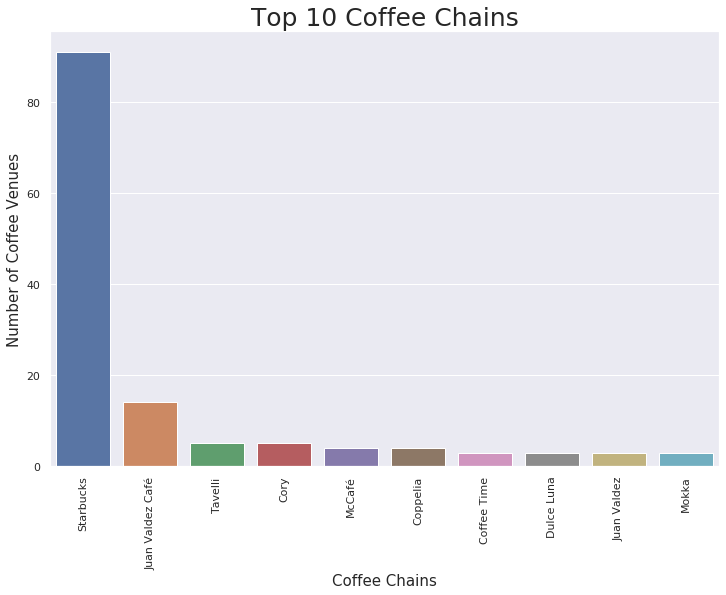

In [0]:
Top10= pd.DataFrame(stgo_coffees['Coffee Name'].value_counts().head(10)).reset_index()
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(Top10['index'], Top10['Coffee Name'])
plt.xlabel('Coffee Chains', fontsize=15)
plt.ylabel('Number of Coffee Venues', fontsize=15)
plt.title('Top 10 Coffee Chains', fontsize=25)
plt.xticks(rotation = 90)
plt.show()

In [0]:
#stgo_coffees['Commune'] = ""
key = 'd3495a60a3e2464f151f9af4ba5fa394e1a18af4'

for i in range(0,len(stgo_coffees)):
  lat = stgo_coffees.iloc[i,2]
  lng = stgo_coffees.iloc[i,3]
  url = 'https://api.desarrolladores.datos.gob.cl/datos-georeferenciados-de-territorio/v1/comunas.json/?auth_key={}&longitud={}&latitud={}'.format(
    key,
    lng,
    lat
  )
  
  try:

    response = requests.get(url)
    stgo_coffees.iloc[i,5] = response.json()['comuna']['nombreComuna']
  
  except KeyError:
    print('Request denegada desde la fila '+ str(i))
    raise
stgo_coffees

,id,Coffee Name,CN Latitude,CN Longitude,Category,Commune
0,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café,SAN MIGUEL
1,58530b0edebdf67a4d7a812d,Starbucks,-33.451241,-70.679164,Coffee Shop,ESTACIÓN CENTRAL
2,55e7894a498ea1b894714623,Starbucks,-33.516439,-70.716791,Coffee Shop,CERRILLOS
3,513363dbe4b08f70f9cef67d,Caffe Codice,-33.498026,-70.653820,Coffee Shop,SAN MIGUEL
4,4bcb2d58937ca593f4f7a892,Starbucks,-33.483698,-70.750360,Coffee Shop,MAIPÚ
...,...,...,...,...,...,...
492,4bede0cfa40fc928a1ab820c,Fides Café,-33.388119,-70.568491,Café,VITACURA
493,4b61e414f964a52078292ae3,The Coffee Factory,-33.414565,-70.595725,Café,LAS CONDES
494,4b6ac8b5f964a5202be02be3,Starbucks,-33.413817,-70.599993,Coffee Shop,LAS CONDES
495,4c39e50e1e06d13a00457a3e,Café Melba,-33.415752,-70.600059,Café,LAS CONDES


In [0]:
stgo_coffees['Commune'].value_counts()

LAS CONDES          104
SANTIAGO             89
PROVIDENCIA          63
ÑUÑOA                44
VITACURA             38
MAIPÚ                17
ESTACIÓN CENTRAL     15
HUECHURABA           14
LA FLORIDA           13
PEÑALOLÉN            12
LO BARNECHEA         12
LA REINA              9
PUENTE ALTO           9
RECOLETA              7
SAN BERNARDO          5
RENCA                 5
QUILICURA             5
MACUL                 4
LA CISTERNA           4
CERRILLOS             4
SAN MIGUEL            4
PIRQUE                3
SAN RAMÓN             3
PUDAHUEL              2
INDEPENDENCIA         2
SAN JOAQUÍN           2
QUINTA NORMAL         2
CALERA DE TANGO       2
LO PRADO              1
CERRO NAVIA           1
EL BOSQUE             1
LO ESPEJO             1
Name: Commune, dtype: int64

In [0]:
stgo_coffees.drop(stgo_coffees[stgo_coffees['Commune'].isin(['CALERA DE TANGO', 'PIRQUE'])].index, inplace = True)
stgo_coffees = stgo_coffees.reset_index(drop=True)
print('There are '+ str(stgo_coffees['Commune'].nunique()) +' Communes with Coffee Venues')

There are 30 Communes with Coffee Venues


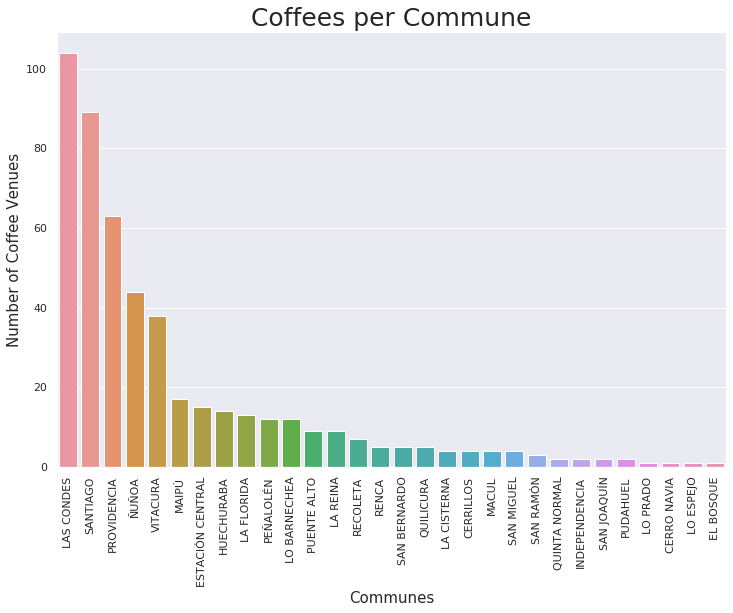

In [0]:
cp_commune= pd.DataFrame(stgo_coffees['Commune'].value_counts()).reset_index()
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(cp_commune['index'], cp_commune['Commune'])
plt.xlabel('Communes', fontsize=15)
plt.ylabel('Number of Coffee Venues', fontsize=15)
plt.title('Coffees per Commune', fontsize=25)
plt.xticks(rotation = 90)
plt.show()

In [0]:
#coffee venue per capita
sc = stgo_coffees['Commune'].value_counts()
sc = pd.DataFrame(sc).reset_index()
df_stgo['Commune'] = df_stgo['Commune'].str.upper()
sc = sc.join(df_stgo.set_index('Commune'), on='index')
sc = sc.rename(columns= {"index": "Commune", 
                   "Commune": "Coffee Venues",
                   "Population 2017": "Population"})
sc['Coffee per Capita'] = sc['Population']/sc['Coffee Venues']
sc = sc.round(2)
sc

,Commune,Coffee Venues,Population,Coffee per Capita
0,LAS CONDES,104,294838,2834.98
1,SANTIAGO,89,404495,4544.89
2,PROVIDENCIA,63,142079,2255.22
3,ÑUÑOA,44,208237,4732.66
4,VITACURA,38,85384,2246.95
5,MAIPÚ,17,521627,30683.94
6,ESTACIÓN CENTRAL,15,147041,9802.73
7,HUECHURABA,14,98671,7047.93
8,LA FLORIDA,13,366916,28224.31
9,PEÑALOLÉN,12,241599,20133.25


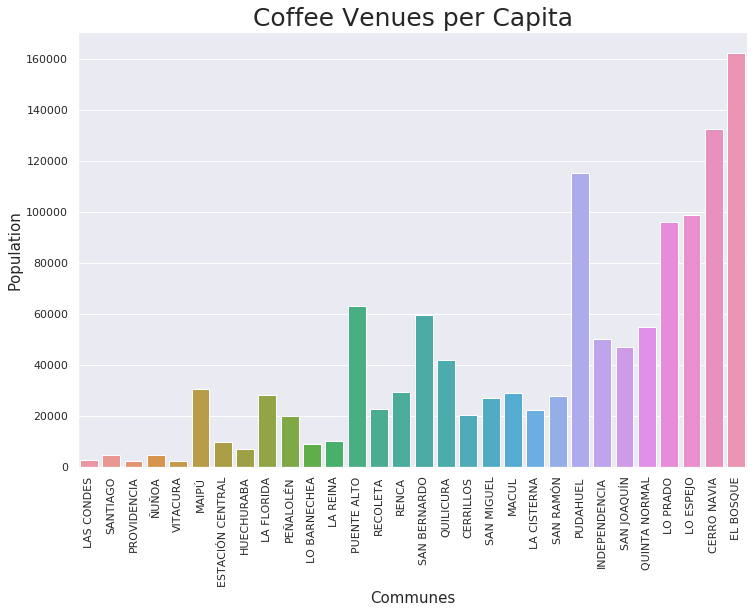

In [0]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(sc['Commune'], sc['Coffee per Capita'])
plt.xlabel('Communes', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.title('Coffee Venues per Capita', fontsize=25)
plt.xticks(rotation = 90)
plt.show()

In [0]:
#stgo_coffees.to_csv('df_coffees_final.csv', index = None) 
#files.download('df_coffees_final.csv')

### Map Coffee Venues

In [0]:
map_coffees = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, coffee, commune in zip(stgo_coffees['CN Latitude'], stgo_coffees['CN Longitude'], stgo_coffees['Coffee Name'], stgo_coffees['Commune']):
    label = '{}, {}'.format(coffee, commune)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#ffc505',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffees)  
    
map_coffees

In [0]:
from folium import plugins
from folium.plugins import HeatMap

map_coffees_2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
CoffeesArr = stgo_coffees[['CN Latitude', 'CN Longitude']].as_matrix()

# plot heatmap
map_coffees_2.add_children(plugins.HeatMap(CoffeesArr, radius=15))
 
    
map_coffees_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  # Remove the CWD from sys.path while we load stuff.


### GET - nearby venues to each coffee venue

In [0]:
Recreation = '4d4b7105d754a06377d81259'
Cultural = '4d4b7104d754a06370d81259'
Universities = '4d4b7105d754a06372d81259'
Professionals = '4d4b7105d754a06375d81259'
Services_store = '4d4b7105d754a06378d81259'
Transport = '4d4b7105d754a06379d81259'

Venues_categories_ID = 

In [0]:
def getNearbyVenues(ID, names, latitudes, longitudes, radius=300, LIMIT = 100):

    venues_list=[]
    
    for ID, name, lat, lng in zip(ID, names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT)
          
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ID,
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

      


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['id', 
                  'Coffee Name', 
                  'CN Latitude', 
                  'CN Longitude',
                  'id Venue', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
nearby_venues = getNearbyVenues(ID = stgo_coffees['id'], 
                                names = stgo_coffees['Coffee Name'],
                                latitudes = stgo_coffees['CN Latitude'], 
                                longitudes = stgo_coffees['CN Longitude'])

In [0]:
print(nearby_venues.shape)
nearby_venues.head()

(12285, 9)


,id,Coffee Name,CN Latitude,CN Longitude,id Venue,Venue,Venue Latitude,Venue Longitude,Venue Category
0,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café
1,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,50ef413ee4b0aef77445bd26,Kingu Sushi,-33.498741,-70.653602,Sushi Restaurant
2,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,513363dbe4b08f70f9cef67d,Caffe Codice,-33.498026,-70.653820,Coffee Shop
3,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,516ad890e4b0115528706e8a,Okita - Peruvian & Japanese,-33.497792,-70.655281,Peruvian Restaurant
4,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,4fd6a290e4b0da5c74b5bd99,Papa John's,-33.499511,-70.653993,Pizza Place


In [0]:
nearby_venues['id'].value_counts()

5a465668e185f31fd1d34fe7    87
4fd8f3a1e4b0b01132012d3c    82
51b3d985498e967c1b6d364f    81
51ea951c498edfd8d8286551    80
566e3c4e498e58ba3b7a1f5b    77
                            ..
4e024ecd88776240d3f7c182     2
5213b32911d22ed87734f645     2
4e5d19d01f6e330fd1b18986     1
4e5235f2d1643fe916379790     1
4e382e7ab61c5cb3c387f094     1
Name: id, Length: 491, dtype: int64

In [0]:
nearby_venues.to_csv('df_nearby_venues3.csv', index = None) 
files.download('df_nearby_venues3.csv')

In [0]:
filter = nearby_venues['Venue Category'].isin(['Coffee Shop', 'Café', 'Tea Room', 'Cafeteria', 'College Cafeteria' ])
other_venues = nearby_venues[filter==False].reset_index(drop=True)
print(other_venues.shape)
other_venues['id'].value_counts()

(10763, 9)


5a465668e185f31fd1d34fe7    80
4fd8f3a1e4b0b01132012d3c    76
51b3d985498e967c1b6d364f    75
51ea951c498edfd8d8286551    74
56911658498ed86bf61280ec    69
                            ..
4e29eab152b1b8f19850bcd4     1
4cdacf9efc973704bee5ca05     1
4e024ecd88776240d3f7c182     1
4e4eabb2d164978659bf21f3     1
514b337ce4b0d7d598f57667     1
Name: id, Length: 485, dtype: int64

In [0]:
filter2 = other_venues['Venue Category'].str.contains(pat='Restaurant|Burger|Sandwich|Ice|Breakfast|Bakery|Snack|Pizza|Hot Dog|Chicken|Food|Donut')
other_venues = other_venues[filter2==False].reset_index(drop=True)
print(other_venues.shape)
other_venues['id'].value_counts()

(6012, 9)


51ea951c498edfd8d8286551    55
56911658498ed86bf61280ec    52
5a465668e185f31fd1d34fe7    52
598f7588c4df1d322fd1c77b    51
51b3d985498e967c1b6d364f    50
                            ..
4f249861e4b0a93fbf1f5972     1
56eae5f8cd10fb42d930b97d     1
4c564ce22308be9ad2c4566c     1
4e199e0a45dd120c1219cf6b     1
4e29eab152b1b8f19850bcd4     1
Name: id, Length: 478, dtype: int64

In [0]:
NV_group = other_venues.groupby('id').count()
NV_group

,Coffee Name,CN Latitude,CN Longitude,id Venue,Venue,Venue Latitude,Venue Longitude,Venue Category
id,,,,,,,,
4b44cd2df964a52092fc25e3,39,39,39,39,39,39,39,39
4b50d1f9f964a520a13327e3,31,31,31,31,31,31,31,31
4b52156bf964a5208e6627e3,11,11,11,11,11,11,11,11
4b548636f964a5208abe27e3,21,21,21,21,21,21,21,21
4b55ac55f964a52051eb27e3,29,29,29,29,29,29,29,29
...,...,...,...,...,...,...,...,...
5b6081e01c0b34002e2f147b,14,14,14,14,14,14,14,14
5b69e42e628c83002c1d59ae,8,8,8,8,8,8,8,8
5b70bb8d419a9e0039debe29,13,13,13,13,13,13,13,13


There are 236 uniques categories.


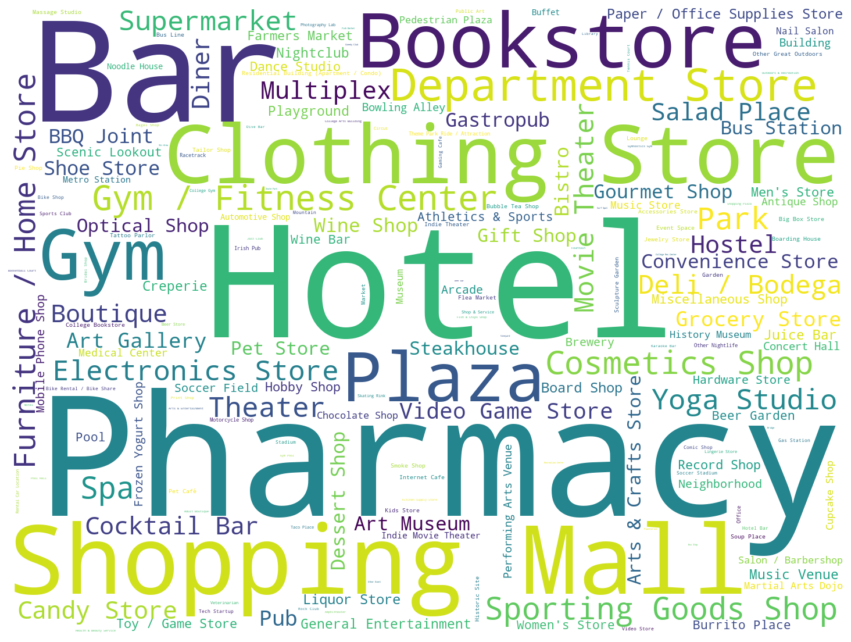

In [0]:
from wordcloud import WordCloud
wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5, background_color="white").generate_from_frequencies(other_venues['Venue Category'].value_counts()))

print('There are {} uniques categories.'.format(len(other_venues['Venue Category'].unique())))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Preprocessing for Clustering

In [0]:
# one hot encoding
onehot = pd.get_dummies(other_venues[['Venue Category']], prefix="", prefix_sep="")

# add id column back to dataframe
onehot['id'] = other_venues['id']

print(onehot.shape)
onehot.head()

(6002, 242)


,Accessories Store,Adult Boutique,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bar,Basketball Court,Basketball Stadium,Bathing Area,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burrito Place,...,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,Soccer Stadium,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Strip Club,Supermarket,Surf Spot,Taco Place,Tailor Shop,Tattoo Parlor,Tech Startup,Temple,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Trail,Travel Agency,Veterinarian,Video Game Store,Video Store,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit,id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579d50ac498e20f50df24db8
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579d50ac498e20f50df24db8
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579d50ac498e20f50df24db8
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579d50ac498e20f50df24db8
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58530b0edebdf67a4d7a812d


In [0]:
grouped = onehot.groupby('id').sum().reset_index()
grouped

,id,Accessories Store,Adult Boutique,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bar,Basketball Court,Basketball Stadium,Bathing Area,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,...,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Soccer Field,Soccer Stadium,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Strip Club,Supermarket,Surf Spot,Taco Place,Tailor Shop,Tattoo Parlor,Tech Startup,Temple,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Trail,Travel Agency,Veterinarian,Video Game Store,Video Store,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,4b44cd2df964a52092fc25e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,4b50d1f9f964a520a13327e3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4b52156bf964a5208e6627e3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4b548636f964a5208abe27e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4b55ac55f964a52051eb27e3,0,0,0,0,0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,5b6081e01c0b34002e2f147b,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
477,5b69e42e628c83002c1d59ae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
478,5b70bb8d419a9e0039debe29,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479,5ccb87e7065ef5002cf7e34e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from sklearn import preprocessing
#Feature = pd.merge(grouped, stgo_coffees, on='id', how='inner')
#Feature = pd.merge(Feature, sc, on='Commune', how='inner')
#Feature = Feature.drop({'id','Coffee Name', 'CN Latitude', 'CN Longitude', 'Category', 'Commune', 'Coffee Venues', 'Population'}, axis=1)
grouped_clustering = grouped.drop('id', 1)
Feature = preprocessing.StandardScaler().fit(grouped_clustering).transform(grouped_clustering)
Feature

array([[-0.16357923, -0.08152805, -0.09154773, ..., -0.14984992,
        -0.34398586, -0.0643506 ],
       [-0.16357923, -0.08152805, -0.09154773, ..., -0.14984992,
        -0.34398586, -0.0643506 ],
       [-0.16357923, -0.08152805, -0.09154773, ..., -0.14984992,
        -0.34398586, -0.0643506 ],
       ...,
       [-0.16357923, -0.08152805, -0.09154773, ..., -0.14984992,
        -0.34398586, -0.0643506 ],
       [-0.16357923, -0.08152805, -0.09154773, ..., -0.14984992,
        -0.34398586, -0.0643506 ],
       [-0.16357923, -0.08152805, -0.09154773, ..., -0.14984992,
        -0.34398586, -0.0643506 ]])

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [0]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
other_venues_sorted = pd.DataFrame(columns=columns)
other_venues_sorted['id'] = grouped['id']

for ind in np.arange(grouped.shape[0]):
    other_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

other_venues_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4b44cd2df964a52092fc25e3,Hotel,Bookstore,Boutique,Nightclub,Spa,Frozen Yogurt Shop,Diner,Men's Store,Record Shop,Hobby Shop
1,4b50d1f9f964a520a13327e3,Hotel,Bookstore,Paper / Office Supplies Store,Hotel Bar,Brewery,Gift Shop,Men's Store,Spa,Soup Place,Frozen Yogurt Shop
2,4b52156bf964a5208e6627e3,Bookstore,BBQ Joint,Shopping Mall,Salad Place,Candy Store,Gym,Museum,Theater,Gym / Fitness Center,Art Museum
3,4b548636f964a5208abe27e3,Bookstore,Scenic Lookout,Theater,Residential Building (Apartment / Condo),Candy Store,Noodle House,Bubble Tea Shop,Movie Theater,Mountain,Boarding House
4,4b55ac55f964a52051eb27e3,Hotel,Art Museum,Hostel,Cocktail Bar,Optical Shop,Yoga Studio,Theater,Pet Store,Record Shop,Nightclub


### Optimal K in K-Means Alghoritm

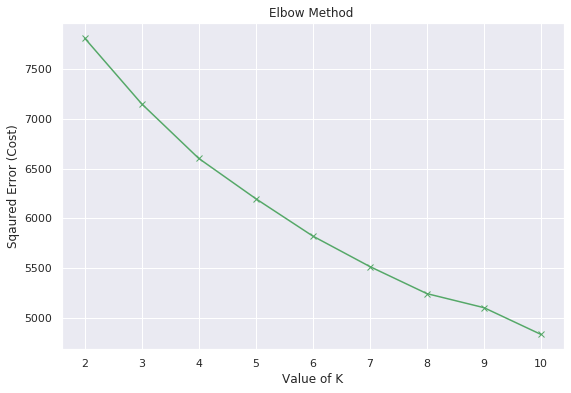

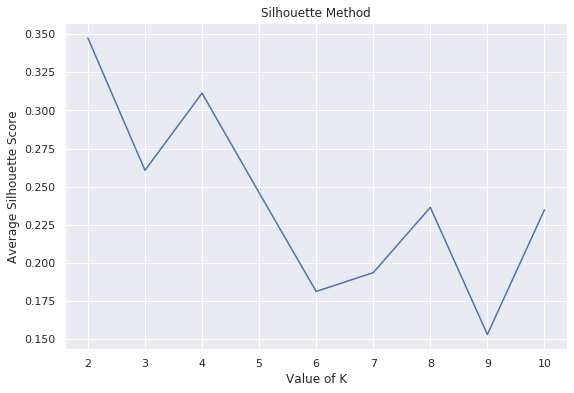

In [0]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

grouped_clustering = grouped.drop('id', 1)
#grouped_clustering = Feature

cost = []
silhouette = []
Ks = range(2, 11)
for i in Ks:

  # run k-means clustering
  kmeans = KMeans(n_clusters=i, random_state=2).fit(grouped_clustering)


  # calculates squared error for the clustered points
  cost.append(kmeans.inertia_)

  silhouette.append(silhouette_score(grouped_clustering, kmeans.labels_ ,metric='euclidean'))

# plot the cost against K values
plt.figure(figsize=(9,6))
plt.plot(Ks, cost, 'bx-', color ='g') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.title("Elbow Method ") 
plt.show()
print('')
plt.figure(figsize=(9,6))
plt.plot(Ks, silhouette)
plt.xlabel("Value of K") 
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Method")
plt.show()

In [0]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(grouped_clustering)
distances, indices = nbrs.kneighbors(grouped_clustering)


In [0]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [0]:
from sklearn.cluster import DBSCAN
dbscan_model = DBSCAN(eps = 0.4, min_samples = 2).fit(grouped_clustering) 
labels = dbscan_model.labels_

# check cluster labels generated for each row in the dataframe
print(set(labels))
labels

In [0]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters).fit(grouped_clustering)

In [0]:
# add clustering labels
other_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = stgo_coffees

# merge toronto_grouped with toronto_data to add latitude/longitude for each id
df_merged = df_merged.join(other_venues_sorted.set_index('id'), on='id')

df_merged = df_merged.drop('Commune', axis=1)
df_merged = df_merged.dropna()
df_merged = df_merged.astype({"Cluster Labels":'int64'})

print(df_merged['Cluster Labels'].value_counts())
df_merged.head() # check the last columns!

1    343
0     64
3     58
2     16
Name: Cluster Labels, dtype: int64


,id,Coffee Name,CN Latitude,CN Longitude,Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,579d50ac498e20f50df24db8,Cocó Café,-33.497172,-70.654912,Café,1,Playground,Pub,Liquor Store,Grocery Store,Dessert Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market
1,58530b0edebdf67a4d7a812d,Starbucks,-33.451241,-70.679164,Coffee Shop,0,Pharmacy,Shopping Mall,Planetarium,Paper / Office Supplies Store,Spa,Sporting Goods Shop,Bistro,Bus Line,Bus Station,Salad Place
2,55e7894a498ea1b894714623,Starbucks,-33.516439,-70.716791,Coffee Shop,0,Department Store,Furniture / Home Store,Clothing Store,Pharmacy,Shoe Store,Movie Theater,Shopping Mall,Bus Station,Bus Line,Mobile Phone Shop
3,513363dbe4b08f70f9cef67d,Caffe Codice,-33.498026,-70.653820,Coffee Shop,1,Playground,Gastropub,BBQ Joint,Liquor Store,Gym,Grocery Store,Pub,Farmers Market,Fabric Shop,Fish & Chips Shop
4,4bcb2d58937ca593f4f7a892,Starbucks,-33.483698,-70.750360,Coffee Shop,0,Sporting Goods Shop,Department Store,Shopping Mall,Video Game Store,Multiplex,Electronics Store,Women's Store,Pharmacy,Movie Theater,Burrito Place


### Coffee Clusters

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['CN Latitude'], df_merged['CN Longitude'], df_merged['Coffee Name'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0

In [0]:
cluster0 = df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
cluster0

,Coffee Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Starbucks,0,Pharmacy,Shopping Mall,Planetarium,Paper / Office Supplies Store,Spa,Sporting Goods Shop,Bistro,Bus Line,Bus Station,Salad Place
2,Starbucks,0,Department Store,Furniture / Home Store,Clothing Store,Pharmacy,Shoe Store,Movie Theater,Shopping Mall,Bus Station,Bus Line,Mobile Phone Shop
4,Starbucks,0,Sporting Goods Shop,Department Store,Shopping Mall,Video Game Store,Multiplex,Electronics Store,Women's Store,Pharmacy,Movie Theater,Burrito Place
5,Juan Valdez Café,0,Sporting Goods Shop,Department Store,Pharmacy,Video Game Store,Multiplex,Burrito Place,Supermarket,Electronics Store,Gaming Cafe,Miscellaneous Shop
6,Pannacota,0,Sporting Goods Shop,Department Store,Pharmacy,Video Game Store,Multiplex,Burrito Place,Supermarket,Electronics Store,Gaming Cafe,Miscellaneous Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
462,Xurros Café,0,Pharmacy,Mobile Phone Shop,Supermarket,Playground,Convenience Store,Clothing Store,Department Store,Bus Stop,Diner,Bus Line
471,Cory,0,Department Store,Shopping Mall,Clothing Store,Music Store,Movie Theater,Supermarket,Gastropub,Gym / Fitness Center,Bookstore,Jewelry Store
473,Coppelia,0,Shopping Mall,Department Store,Playground,Clothing Store,Music Store,Bookstore,Movie Theater,Gastropub,Gym / Fitness Center,Soccer Field
478,Casino,0,Accessories Store,Clothing Store,Diner,Bowling Alley,Theater,Burrito Place,Department Store,Supermarket,Shoe Store,Electronics Store


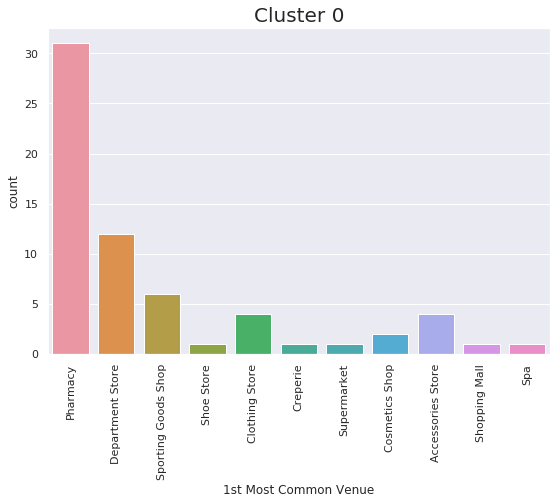

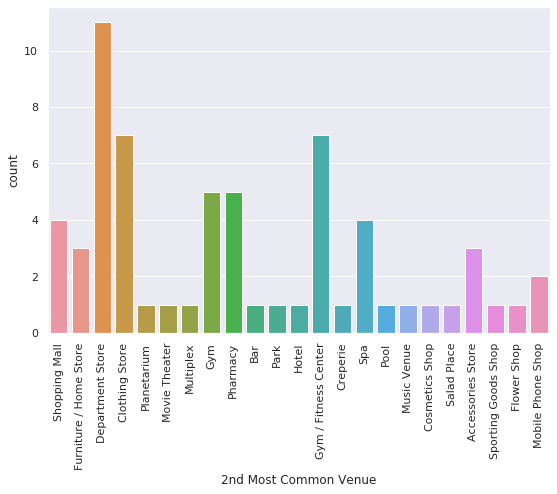

In [0]:
plt.figure(figsize=(9,6))
sns.countplot(cluster0['1st Most Common Venue'])
plt.xticks(rotation = 90)
plt.title('Cluster 0', size=20)
plt.show()

plt.figure(figsize=(9,6))
second=sns.countplot(cluster0['2nd Most Common Venue'])
plt.xticks(rotation = 90)
plt.show()

Cluster 1

In [0]:
cluster1 = df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
cluster1

,Coffee Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cocó Café,1,Playground,Pub,Liquor Store,Grocery Store,Dessert Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market
3,Caffe Codice,1,Playground,Gastropub,BBQ Joint,Liquor Store,Gym,Grocery Store,Pub,Farmers Market,Fabric Shop,Fish & Chips Shop
12,Cafeteria Bicentenario by Sodexo,1,Residential Building (Apartment / Condo),Zoo Exhibit,Dessert Shop,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market,Fabric Shop
13,Coffeebreak,1,Metro Station,Zoo Exhibit,Fruit & Vegetable Store,Fountain,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market
14,Coffee Market,1,Bus Station,Dessert Shop,Pharmacy,Music Store,Diner,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
482,Café Helarte,1,Bistro,Bar,Zoo Exhibit,Distillery,Fountain,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
483,Café Cariño,1,Concert Hall,Racetrack,Furniture / Home Store,Bookstore,Big Box Store,Gourmet Shop,Martial Arts Dojo,Shopping Plaza,Bar,Gym / Fitness Center
484,Café Villa Real,1,Shopping Mall,Spa,Salon / Barbershop,Candy Store,Gift Shop,Toy / Game Store,Electronics Store,Distillery,Dive Bar,Event Space
485,Starbucks,1,Spa,Gift Shop,Candy Store,Salon / Barbershop,Shopping Mall,Yoga Studio,Fish & Chips Shop,Farmers Market,Fabric Shop,Dessert Shop


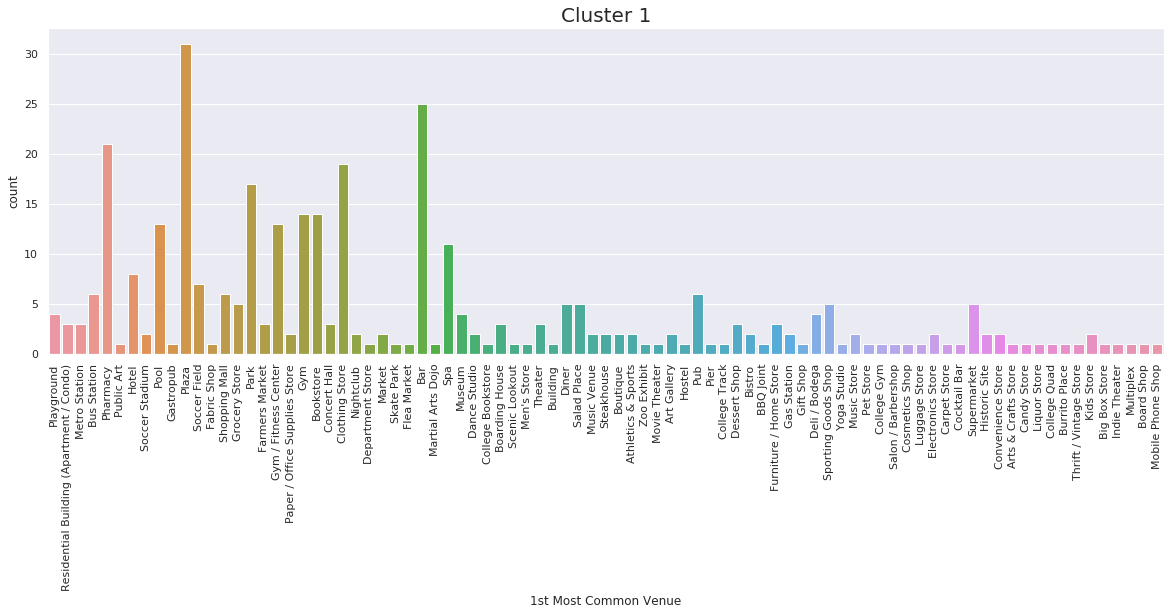

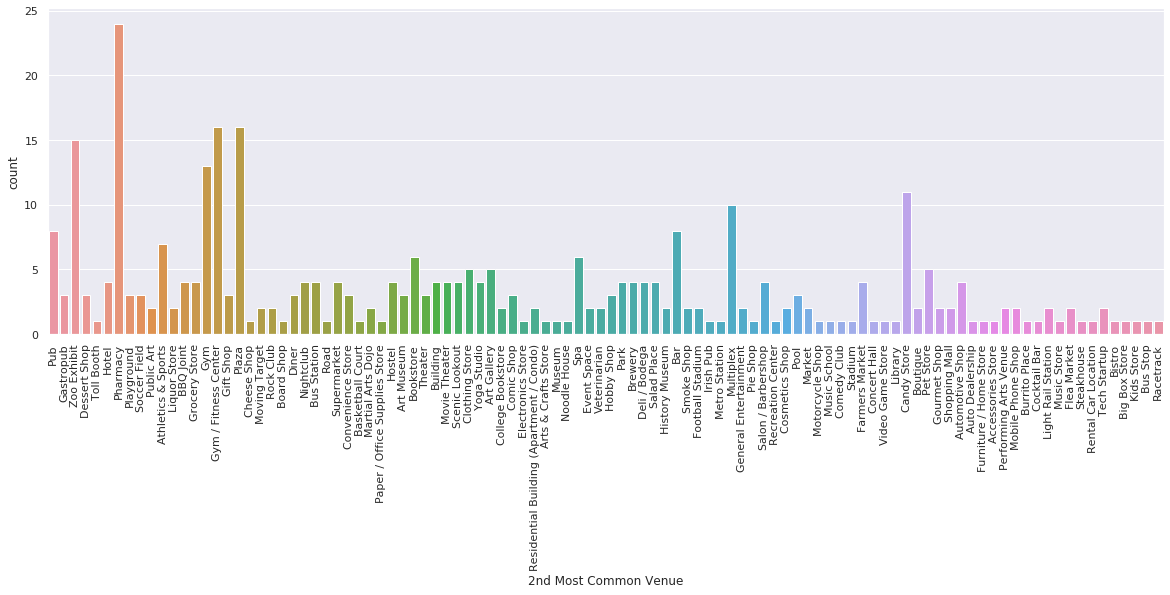

In [0]:
plt.figure(figsize=(20,6))
sns.countplot(cluster1['1st Most Common Venue'])
plt.xticks(rotation = 90)
plt.title('Cluster 1', size=20)
plt.show()

plt.figure(figsize=(20,6))
second=sns.countplot(cluster1['2nd Most Common Venue'])
plt.xticks(rotation = 90)
plt.show()

Cluster 2

In [0]:
cluster2 = df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
cluster2

,Coffee Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
182,Cacao Much,2,Clothing Store,Creperie,Gourmet Shop,Candy Store,Bookstore,Nail Salon,Cosmetics Shop,Sporting Goods Shop,Boutique,Shopping Mall
192,Juan Valdez Café,2,Sporting Goods Shop,Cosmetics Shop,Paper / Office Supplies Store,Electronics Store,Gym,Shopping Mall,Bookstore,Bowling Alley,Beer Garden,Furniture / Home Store
193,Starbucks,2,Sporting Goods Shop,Cosmetics Shop,Shopping Mall,Bar,Paper / Office Supplies Store,Electronics Store,Gym,Bookstore,Furniture / Home Store,Board Shop
195,Cory,2,Sporting Goods Shop,Cosmetics Shop,Shopping Mall,Bar,Paper / Office Supplies Store,Electronics Store,Gym,Bookstore,Furniture / Home Store,Board Shop
196,McCafé,2,Sporting Goods Shop,Cosmetics Shop,Electronics Store,Gym,Pharmacy,Paper / Office Supplies Store,Shopping Mall,Furniture / Home Store,Board Shop,Soccer Field
202,Adagio Teas,2,Sporting Goods Shop,Cosmetics Shop,Electronics Store,Gym,Paper / Office Supplies Store,Pub,Shopping Mall,Furniture / Home Store,Board Shop,Soccer Field
203,Big John,2,Cosmetics Shop,Sporting Goods Shop,Shopping Mall,Electronics Store,Bookstore,Department Store,Skating Rink,Bowling Alley,Music Store,Pharmacy
211,Cafetería Duoc UC,2,Sporting Goods Shop,Cosmetics Shop,Paper / Office Supplies Store,Electronics Store,Bar,Shopping Mall,Bookstore,Pharmacy,Beer Garden,Gastropub
293,Inside Tea Connection,2,Clothing Store,Boutique,Cosmetics Shop,Men's Store,Women's Store,Shoe Store,Multiplex,Department Store,Sporting Goods Shop,Spa
295,Starbucks,2,Clothing Store,Boutique,Cosmetics Shop,Women's Store,Men's Store,Sporting Goods Shop,Furniture / Home Store,Department Store,Park,Multiplex


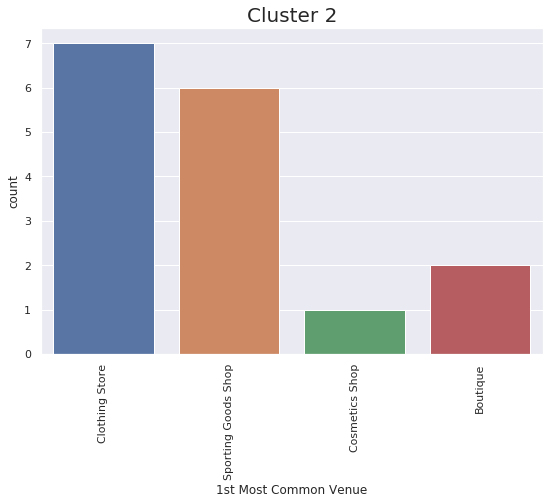

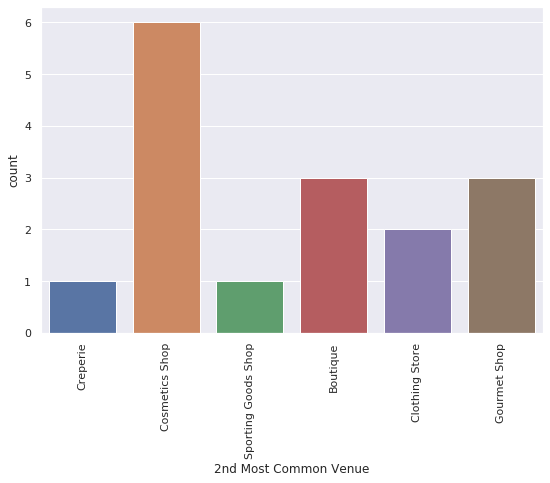

In [0]:
plt.figure(figsize=(9,6))
sns.countplot(cluster2['1st Most Common Venue'])
plt.xticks(rotation = 90)
plt.title('Cluster 2', size=20)
plt.show()

plt.figure(figsize=(9,6))
second=sns.countplot(cluster2['2nd Most Common Venue'])
plt.xticks(rotation = 90)
plt.show()

Cluster 3

In [0]:
cluster3 = df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
cluster3

,Coffee Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Sur Café,3,Hostel,Art Museum,Plaza,Theater,Yoga Studio,Historic Site,Neighborhood,Nightclub,Optical Shop,Diner
83,Starbucks,3,Bookstore,Hotel,Shopping Mall,Gym,Pet Store,Dessert Shop,Candy Store,Event Space,Burrito Place,Nightclub
92,Café Crónica Digital,3,Bar,Cocktail Bar,Irish Pub,Neighborhood,Organic Grocery,Steakhouse,Pub,Sports Club,Hostel,Hotel
95,Milagritos,3,Bookstore,Hostel,Yoga Studio,Hotel,Garden,Optical Shop,Tailor Shop,Shopping Mall,Neighborhood,Miscellaneous Shop
96,Bloom Specialty Coffee,3,Hotel,Art Gallery,Cocktail Bar,Spa,Gift Shop,Nightclub,Neighborhood,Miscellaneous Shop,Record Shop,Park
98,Wonderland Café,3,Hotel,Art Gallery,Cocktail Bar,Scenic Lookout,Gift Shop,Nightclub,Neighborhood,Record Shop,Miscellaneous Shop,Park
100,Starbucks,3,Hotel,Art Gallery,Cocktail Bar,Scenic Lookout,Beer Garden,Wine Bar,Yoga Studio,Shopping Mall,Gift Shop,Miscellaneous Shop
101,Colmado,3,Hotel,Art Gallery,Cocktail Bar,Beer Garden,Gift Shop,Nightclub,Miscellaneous Shop,Record Shop,Park,Neighborhood
106,Milagritos,3,Hotel,Art Museum,Hostel,Cocktail Bar,Optical Shop,Yoga Studio,Theater,Pet Store,Record Shop,Nightclub
107,Dómestico,3,Hotel,Pedestrian Plaza,Wine Bar,Beer Garden,Art Gallery,Shopping Mall,Park,Gift Shop,Cocktail Bar,Scenic Lookout


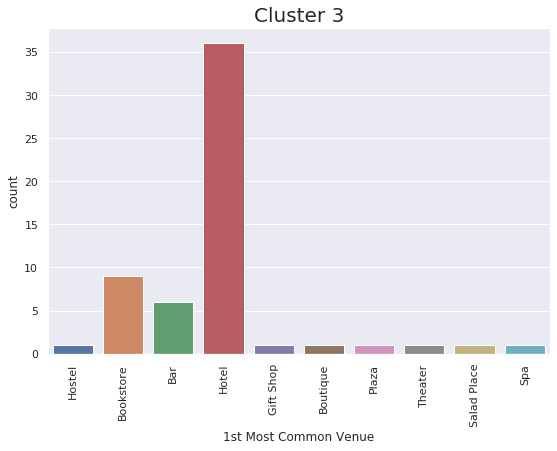

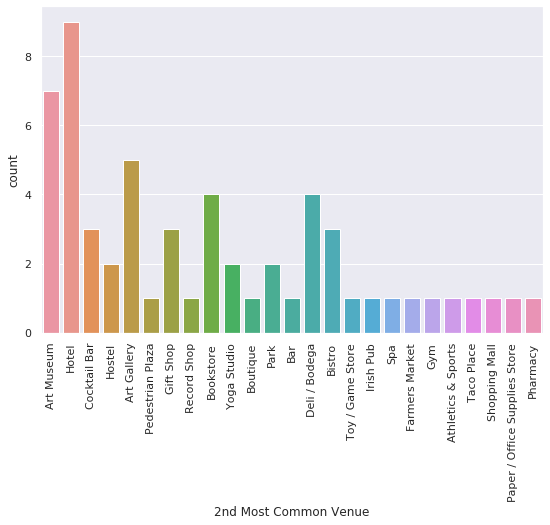

In [0]:
plt.figure(figsize=(9,6))
sns.countplot(cluster3['1st Most Common Venue'])
plt.xticks(rotation = 90)
plt.title('Cluster 3', size=20)
plt.show()

plt.figure(figsize=(9,6))
second=sns.countplot(cluster3['2nd Most Common Venue'])
plt.xticks(rotation = 90)
plt.show()

### Similar places without coffee stores
### Potential Venues for new Coffee stores

In [0]:
def getSimilarVenues(names, latitudes, longitudes, radius, LIMIT = 100):
    
    pharmacy = '4bf58dd8d48988d10f951735'
    plaza = '4bf58dd8d48988d164941735'
    park = '4bf58dd8d48988d163941735'
    hotel = '4bf58dd8d48988d1fa931735'
    clothing_store = '4bf58dd8d48988d103951735'
    bookstore = '4bf58dd8d48988d114951735'
    departament_store = '4bf58dd8d48988d1f6941735'
    art_museum = '4bf58dd8d48988d18f941735'
    art_gallery = '4bf58dd8d48988d1e2931735'
    bar = '4bf58dd8d48988d116941735'

    categories = pharmacy + ',' + plaza + ',' + park + ',' + hotel + ',' + clothing_store + ',' + bookstore + ',' + departament_store + ',' + art_museum + ',' + art_gallery + ',' + bar

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            categories,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    similar_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    similar_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude',
                  'id', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(similar_venues)

In [0]:
original_venues = getSimilarVenues(names = stgo_coffees['Coffee Name'],
                                   latitudes = stgo_coffees['CN Latitude'],
                                   longitudes = stgo_coffees['CN Longitude'],
                                   radius = 300)

In [0]:
print(original_venues.shape)
original_venues = original_venues.rename(columns={'id':'id2'})
original_venues.head()

(10985, 8)


,Commune,Commune Latitude,Commune Longitude,id2,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cocó Café,-33.497172,-70.654912,4ca547b9b7106dcba27353a5,Farmacias Ahumada,-33.499521,-70.653993,Pharmacy
1,Cocó Café,-33.497172,-70.654912,4f8b0ab4e4b060b7f8e75462,Farmacias Cruz Verde,-33.495114,-70.652911,Pharmacy
2,Cocó Café,-33.497172,-70.654912,4dcf46c222718eed7a4f0bf5,Pub Nativo,-33.497097,-70.653326,Pub
3,Starbucks,-33.451241,-70.679164,5044ce7ae4b05e5c10c99b7e,Salcobrand,-33.451417,-70.678822,Pharmacy
4,Starbucks,-33.451241,-70.679164,520b0196bce67eb98a55291d,Salcobrand,-33.450690,-70.678804,Pharmacy


In [0]:
similar_venues = getSimilarVenues(names = stgo_coffees['Coffee Name'],
                                  latitudes = stgo_coffees['CN Latitude'],
                                  longitudes = stgo_coffees['CN Longitude'],
                                  radius = 5000)

In [0]:
print(similar_venues.shape)
similar_venues.head()

(45955, 8)


,Commune,Commune Latitude,Commune Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cocó Café,-33.497172,-70.654912,4f8f5204e4b040e3a767e54f,Museo A Cielo Abierto,-33.502402,-70.660596,Art Gallery
1,Cocó Café,-33.497172,-70.654912,4bc9c96afb84c9b68e941b3e,Parque El Llano,-33.486025,-70.650419,Park
2,Cocó Café,-33.497172,-70.654912,4e97703c9adf6a4ff0980521,Plaza Gabriela Mistral,-33.492914,-70.655340,Plaza
3,Cocó Café,-33.497172,-70.654912,4e62f0a9d4c06542ab2f817d,Bar Mourgues,-33.510232,-70.656906,Bar
4,Cocó Café,-33.497172,-70.654912,4c5052763a6f2d7f97aa5f77,Parque Nacional Del Comic,-33.489376,-70.651290,Park


In [0]:
similar_venues['Venue Category'].value_counts().head(50)

Plaza                            502
Park                             447
Pharmacy                         330
Bar                              256
Department Store                 255
Hotel                            225
Clothing Store                   117
Shoe Store                        35
Bookstore                         35
Supermarket                       31
Art Museum                        31
Shopping Mall                     30
Hardware Store                    30
Art Gallery                       30
Pub                               28
Playground                        19
Women's Store                     14
Furniture / Home Store            13
Nightclub                         11
Boutique                          11
Kids Store                        10
Water Park                         9
Garden                             9
Sporting Goods Shop                8
Paper / Office Supplies Store      8
Motel                              8
Other Great Outdoors               8
B

In [0]:
similar_venues.to_csv('df_similar_venues.csv', index = None) 
files.download('df_similar_venues.csv')

In [0]:
similar_group = similar_venues.groupby('Commune').count().reset_index()
similar_group

,Commune,Commune Latitude,Commune Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3841 Coffee Roasters,100,100,100,100,100,100,100
1,AMADAY,100,100,100,100,100,100,100
2,Adagio Teas,87,87,87,87,87,87,87
3,Alegretto,100,100,100,100,100,100,100
4,ArteSano Café & Boutique,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...
353,cafetín,100,100,100,100,100,100,100
354,dulce luna,100,100,100,100,100,100,100
355,milk,100,100,100,100,100,100,100
356,starbucks clinica tabancura,100,100,100,100,100,100,100


In [0]:
cat = similar_venues['Venue Category'].isin(['Plaza',
                                       'Park',
                                       'Pharmacy',
                                       'Hotel',
                                       'Bar',
                                       'Clothing Store',
                                       'Department Store',
                                       'Art Museum',
                                       'Art Gallery',
                                       'Bookstore']).reset_index(drop=True)

similar_venues_cat = similar_venues[cat]
similar_venues_cat = similar_venues_cat[['id', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
similar_venues_cat = similar_venues_cat[similar_venues_cat.duplicated()==False].reset_index(drop=True) 
similar_venues_cat                                                                                      

,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4f8f5204e4b040e3a767e54f,Museo A Cielo Abierto,-33.502402,-70.660596,Art Gallery
1,4bc9c96afb84c9b68e941b3e,Parque El Llano,-33.486025,-70.650419,Park
2,4e97703c9adf6a4ff0980521,Plaza Gabriela Mistral,-33.492914,-70.655340,Plaza
3,4e62f0a9d4c06542ab2f817d,Bar Mourgues,-33.510232,-70.656906,Bar
4,4c5052763a6f2d7f97aa5f77,Parque Nacional Del Comic,-33.489376,-70.651290,Park
...,...,...,...,...,...
1088,4f846b46e4b0748eb767fb6c,Johnson's Mega,-33.593558,-70.705954,Clothing Store
1089,52111e3c8bbd83bbd5812a13,Salcobrand,-33.592548,-70.704167,Pharmacy
1090,4e7906dad22de127d7b66ab8,Las Araucarias,-33.635176,-70.764392,Park
1091,598bcb44ff190235c7a864fd,Gran Refugio,-33.441864,-70.632500,Bar


In [0]:
cat = original_venues['Venue Category'].isin(['Plaza',
                                       'Park',
                                       'Pharmacy',
                                       'Hotel',
                                       'Bar',
                                       'Clothing Store',
                                       'Department Store',
                                       'Art Museum',
                                       'Art Gallery',
                                       'Bookstore']).reset_index(drop=True)

other_venues_cat = original_venues[cat]
other_venues_cat = other_venues_cat[['id2', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
other_venues_cat = other_venues_cat[other_venues_cat.duplicated()==False].reset_index(drop=True) 
other_venues_cat

,id2,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4ca547b9b7106dcba27353a5,Farmacias Ahumada,-33.499521,-70.653993,Pharmacy
1,4f8b0ab4e4b060b7f8e75462,Farmacias Cruz Verde,-33.495114,-70.652911,Pharmacy
2,5044ce7ae4b05e5c10c99b7e,Salcobrand,-33.451417,-70.678822,Pharmacy
3,520b0196bce67eb98a55291d,Salcobrand,-33.450690,-70.678804,Pharmacy
4,4b6209adf964a520de312ae3,Farmacias Cruz Verde,-33.450780,-70.677464,Pharmacy
...,...,...,...,...,...
1793,509837fde4b0b6c71957cd99,Elizabeth Mercado boutique de muebles,-33.382097,-70.571622,Department Store
1794,53f8bc85498ecc0a79b9ffc3,Qué Leo Vitacura,-33.380621,-70.570723,Bookstore
1795,51e06eab498e65d87aa0fb4b,Benetton Luis Pasteur Vitacura,-33.380517,-70.569868,Clothing Store
1796,4e133632aeb74afe60cce790,Lápiz Lopez,-33.389655,-70.569675,Bookstore


In [0]:
other_similar_venues = similar_venues_cat.merge(other_venues_cat, how='outer')
other_similar_venues.head(50)

,id,Venue,Venue Latitude,Venue Longitude,Venue Category,id2
0,4f8f5204e4b040e3a767e54f,Museo A Cielo Abierto,-33.502402,-70.660596,Art Gallery,NaN
1,4bc9c96afb84c9b68e941b3e,Parque El Llano,-33.486025,-70.650419,Park,NaN
2,4e97703c9adf6a4ff0980521,Plaza Gabriela Mistral,-33.492914,-70.655340,Plaza,NaN
3,4e62f0a9d4c06542ab2f817d,Bar Mourgues,-33.510232,-70.656906,Bar,NaN
4,4c5052763a6f2d7f97aa5f77,Parque Nacional Del Comic,-33.489376,-70.651290,Park,NaN
5,4ea893f377c80957f23b40f0,Farmacias ahumada,-33.493538,-70.652343,Pharmacy,NaN
6,4e6d3dbe7d8bbfa9aeb58ec9,Plaza Llico,-33.505482,-70.644976,Plaza,NaN
7,4c952d7772dd224be74ea191,Parque André Jarlan,-33.487446,-70.665522,Park,NaN
8,4cf566ab1801a1438e42e3d4,Plaza El Llano,-33.482050,-70.651967,Plaza,NaN
9,4d5ea82c1ee8721ed1f99421,Bar Victoria,-33.478727,-70.661537,Bar,NaN


In [0]:
osv = other_similar_venues[other_similar_venues['id2'].isnull()]
osv

,id,Venue,Venue Latitude,Venue Longitude,Venue Category,id2
0,4f8f5204e4b040e3a767e54f,Museo A Cielo Abierto,-33.502402,-70.660596,Art Gallery,NaN
1,4bc9c96afb84c9b68e941b3e,Parque El Llano,-33.486025,-70.650419,Park,NaN
2,4e97703c9adf6a4ff0980521,Plaza Gabriela Mistral,-33.492914,-70.655340,Plaza,NaN
3,4e62f0a9d4c06542ab2f817d,Bar Mourgues,-33.510232,-70.656906,Bar,NaN
4,4c5052763a6f2d7f97aa5f77,Parque Nacional Del Comic,-33.489376,-70.651290,Park,NaN
...,...,...,...,...,...,...
1085,5211566e7e483b8d9700f1b9,Salcobrand,-33.609151,-70.716787,Pharmacy,NaN
1087,4bbb5367cf2fc9b6d56da202,Pucara de Chena,-33.617702,-70.747869,Park,NaN
1088,4f846b46e4b0748eb767fb6c,Johnson's Mega,-33.593558,-70.705954,Clothing Store,NaN
1089,52111e3c8bbd83bbd5812a13,Salcobrand,-33.592548,-70.704167,Pharmacy,NaN


In [0]:
map_potencial_coffees = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, venue, category in zip(osv['Venue Latitude'], osv['Venue Longitude'], osv['Venue'], osv['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#ffc505',
        fill_opacity=0.7,
        parse_html=False).add_to(map_potencial_coffees)  
    
map_potencial_coffees

In [0]:
from folium import plugins
from folium.plugins import HeatMap

map_potencial_coffees2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
osvArr = osv[['Venue Latitude', 'Venue Longitude']].as_matrix()

# plot heatmap
map_potencial_coffees2.add_children(plugins.HeatMap(osvArr, radius=12))
 
    
map_potencial_coffees2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  # Remove the CWD from sys.path while we load stuff.
